In [82]:
# 1. Imports & Setup (Same as before)
# -------------------------------------------------------
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from transformers import AutoModel, AutoTokenizer
from tqdm import tqdm
import os


In [83]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(42)

In [84]:
TRAIN_PATH = "/kaggle/input/russiadataset/rus.csv"
VAL_PATH   = "/kaggle/input/russiadataset/rusval.csv"
TEST_PATH  = "/kaggle/input/russiadataset/rustest.csv"

train_df = pd.read_csv(TRAIN_PATH)
val_df   = pd.read_csv(VAL_PATH)
test_df  = pd.read_csv(TEST_PATH)


In [85]:
train_df.head()

,id,text,anger,disgust,fear,joy,sadness,surprise
0,rus_train_track_a_00001,…каждый индивидуум есть продукт не только суще...,0,0,0,0,0,0
1,rus_train_track_a_00002,Ужасно противно,0,1,0,0,0,0
2,rus_train_track_a_00003,Охуеть я в шоке Пойду выпью что нибудь,0,0,0,0,0,1
3,rus_train_track_a_00004,Так спина болит( ужас(((,0,0,0,0,1,0
4,rus_train_track_a_00005,"леха,мне страшно",0,0,1,0,0,0


In [86]:
# Instead of a single LABEL_VAR, define multiple label columns:
LABEL_COLS = ["anger", "disgust", "fear", "joy", "sadness", "surprise"]
TEXT_VAR   = "text"

In [87]:
# 3. Load Tokenizer & Model for Embedding Extraction
# -------------------------------------------------------
model_name = "MaxKazak/ruBert-base-russian-emotion-detection"
text_tokenizer = AutoTokenizer.from_pretrained(model_name)
text_model = AutoModel.from_pretrained(model_name).to(device)

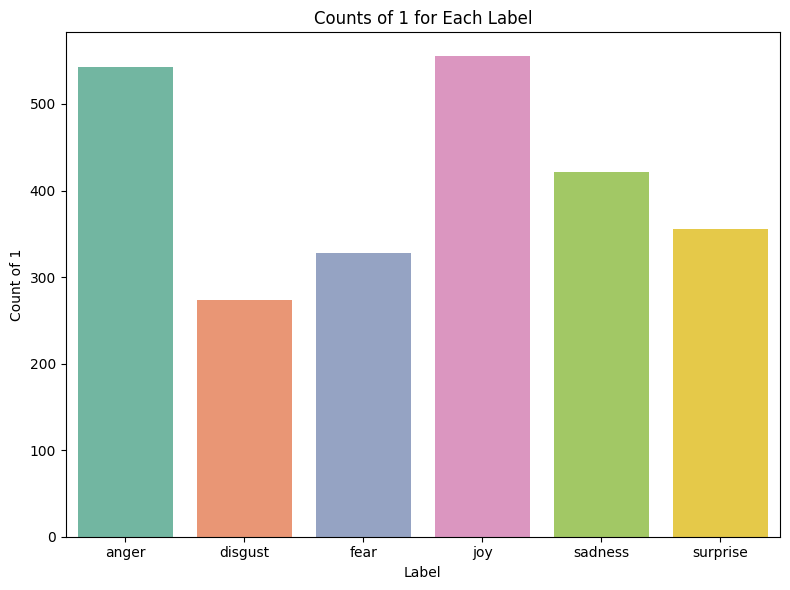

In [88]:
# Collect the counts of "1" for each label
counts_ones = []
for label in LABEL_COLS:
    # Count how many rows in train_df have this label = 1
    num_ones = (train_df[label] == 1).sum()
    counts_ones.append((label, num_ones))

# Build a DataFrame for plotting
counts_df = pd.DataFrame(counts_ones, columns=["label", "count_of_1"])

plt.figure(figsize=(8, 6))
sns.barplot(
    x="label",
    y="count_of_1",
    data=counts_df,
    palette="Set2"
)
plt.title("Counts of 1 for Each Label")
plt.xlabel("Label")
plt.ylabel("Count of 1")
plt.tight_layout()
plt.show()

In [89]:
# 4. Extract Text Embeddings (Same logic, but shorten max_length if needed)
# -------------------------------------------------------
def extract_text_embeddings(df, save_path, model, tokenizer):
    if os.path.exists(save_path):
        print(f"Embeddings already exist at {save_path}")
        return torch.load(save_path)

    embeddings = {}
    model.eval()
    with torch.no_grad():
        for idx, row in tqdm(df.iterrows(), desc="Extracting text embeddings", total=len(df)):
            text_sample = row[TEXT_VAR]
            text_sample = text_sample if isinstance(text_sample, str) else ""

            inputs = tokenizer(
                text_sample,
                padding="max_length",
                truncation=True,
                max_length=128,
                return_tensors="pt"
            ).to(device)

            outputs = model(**inputs)
            cls_embedding = outputs.last_hidden_state[:, 0, :]
            embeddings[idx] = cls_embedding.cpu()

    torch.save(embeddings, save_path)
    return embeddings

train_text_embeddings = extract_text_embeddings(train_df, "train_text_embeddings.pt", text_model, text_tokenizer)
val_text_embeddings   = extract_text_embeddings(val_df,   "val_text_embeddings.pt",   text_model, text_tokenizer)
test_text_embeddings  = extract_text_embeddings(test_df,  "test_text_embeddings.pt",  text_model, text_tokenizer)

Embeddings already exist at train_text_embeddings.pt
Embeddings already exist at val_text_embeddings.pt
Embeddings already exist at test_text_embeddings.pt


In [90]:
# 5. Prepare Embeddings (CHANGED for Multi‐Label)
# -------------------------------------------------------
def prepare_text_embeddings(text_embeddings, df, label_cols=None, has_labels=True):
    """
    For each row in df, gather the text embedding and (optionally) the labels.
    label_cols: list of columns for multi-label (e.g. ["anger", "fear", "joy", ...])
    """
    combined_embeddings = []
    labels = []

    for idx, row in df.iterrows():
        if idx not in text_embeddings:
            continue
        # Get the [CLS] embedding
        text_embedding = text_embeddings[idx].squeeze()  # shape: (768,)
        combined_embeddings.append(text_embedding)

        if has_labels and label_cols is not None:
            # Collect all label columns as a float vector
            label_vector = row[label_cols].values.astype(float)  # shape: (5,)
            labels.append(label_vector)

    # Convert to Tensors
    if has_labels and label_cols is not None:
        X = torch.stack(combined_embeddings)
        Y = torch.tensor(labels, dtype=torch.float)  # multi-label => float
        return X, Y
    else:
        return torch.stack(combined_embeddings)

X_train, y_train = prepare_text_embeddings(train_text_embeddings, train_df, LABEL_COLS, has_labels=True)
X_val,   y_val   = prepare_text_embeddings(val_text_embeddings,   val_df,   LABEL_COLS, has_labels=True)
X_test           = prepare_text_embeddings(test_text_embeddings,  test_df,  LABEL_COLS, has_labels=False)

print("X_train:", X_train.shape, "y_train:", y_train.shape)
print("X_val:  ", X_val.shape,   "y_val:  ", y_val.shape)
print("X_test: ", X_test.shape)


X_train: torch.Size([2679, 768]) y_train: torch.Size([2679, 6])
X_val:   torch.Size([199, 768]) y_val:   torch.Size([199, 6])
X_test:  torch.Size([1000, 768])



def balance_multilabel_data(X, Y):
    """
    Oversample minority label-combinations in a multi-label setting.
    1. Convert each row's label vector (like [1,0,1,0,0]) into a tuple (1.0,0.0,1.0,0.0,0.0).
    2. Count how many rows share that exact tuple (i.e., label combination).
    3. Duplicate those rows until they match the frequency of the most common combination.

    NOTE: This lumps each distinct 5-label pattern as one "class."
    If every row has a unique pattern, this won't help much.
    """
    from collections import Counter

    # Convert each label row to a tuple
    label_tuples = [tuple(row.tolist()) for row in Y]
    class_counts = Counter(label_tuples)
    max_count = max(class_counts.values())

    # We'll store duplicates in lists, then convert to tensors
    balanced_embeddings = []
    balanced_labels = []

    for i, label_tuple in enumerate(label_tuples):
        balanced_embeddings.append(X[i])
        balanced_labels.append(label_tuple)

        current_count = class_counts[label_tuple]
        # e.g., duplicates_needed = how many times to replicate?
        duplicates_needed = int((max_count - current_count) / current_count)

        for _ in range(duplicates_needed):
            balanced_embeddings.append(X[i])
            balanced_labels.append(label_tuple)

    balanced_embeddings = torch.stack(balanced_embeddings)
    balanced_labels = torch.tensor(balanced_labels, dtype=torch.float)
    print(f"Original dataset size: {X.shape[0]}")
    print(f"Balanced dataset size: {balanced_embeddings.shape[0]}")
    return balanced_embeddings, balanced_labels

# Call our new multi-label balancing function
X_train, y_train = balance_multilabel_data(X_train, y_train)


In [91]:
# 6. Define Multi‐Label MLP Model (CHANGED)
# -------------------------------------------------------
class MLPModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout_p=0.5):
        super(MLPModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim[0])
        self.relu = nn.ReLU()
        self.dropout1 = nn.Dropout(p=dropout_p)
        self.fc2 = nn.Linear(hidden_dim[0], hidden_dim[1])
        self.dropout2 = nn.Dropout(p=dropout_p)
        self.fc3 = nn.Linear(hidden_dim[1], output_dim)
        # For multi‐label, we *do not* apply softmax, we will use BCEWithLogitsLoss

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout1(x)
        x = self.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)            # shape: (batch_size, 5)
        # No softmax here for multi‐label. Return raw logits for BCEWithLogitsLoss
        return x


In [92]:
# Model & Hyperparams
input_dim    = X_train.shape[1]        # e.g. 768
hidden_dim   = [786, 512]             # can be tuned
output_dim   = len(LABEL_COLS)        # 5 for multi‐label
dropout_p    = 0.3
num_epochs   = 10
batch_size   = 16
learning_rate = 1e-4

model = MLPModel(input_dim, hidden_dim, output_dim, dropout_p).to(device)

In [93]:
# 7. CHANGED: Use BCEWithLogitsLoss (for multi‐label)
# -------------------------------------------------------
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [94]:
# 8. Dataloaders
# -------------------------------------------------------
train_dataset = TensorDataset(X_train, y_train)
val_dataset   = TensorDataset(X_val,   y_val)
test_dataset  = TensorDataset(X_test)  # no labels for test

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=batch_size)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size)

In [95]:
# 9. Metrics for Multi‐Label (CHANGED)
# -------------------------------------------------------
def calculate_metrics(preds, labels):
    """
    preds, labels are lists (or arrays) of shape (N, 5).
    We'll do an example with macro avg for PRF.
    """
    preds = np.array(preds)
    labels = np.array(labels)

    # Example: For each label, threshold at 0.5
    # (We already do that during loop, but let's be explicit.)
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, preds, average='macro', zero_division=0
    )
    # Multi‐label “accuracy” can be ambiguous.
    # Some do “exact match ratio”, etc. We'll do a simple overall average:
    accuracy = (preds == labels).mean()

    return accuracy, precision, recall, f1

In [96]:
# 10. Train and Validate (CHANGES in Predictions)
# -------------------------------------------------------
def train_and_save_best_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, save_dir):
    best_f1 = -float('inf')
    best_model_path = None

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        all_train_preds, all_train_labels = [], []

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)  # shape: (batch_size, 5)
            # For BCEWithLogitsLoss, labels should be float
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

            # Convert logits -> probabilities -> binary predictions
            preds = (torch.sigmoid(outputs) > 0.5).float()
            all_train_preds.extend(preds.cpu().tolist())
            all_train_labels.extend(labels.cpu().tolist())

        # Training metrics
        train_accuracy, train_precision, train_recall, train_f1 = calculate_metrics(all_train_preds, all_train_labels)

        # Validation
        model.eval()
        val_loss = 0
        all_val_preds, all_val_labels = [], []
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)  # shape: (batch_size, 5)

                loss = criterion(outputs, labels)
                val_loss += loss.item()

                preds = (torch.sigmoid(outputs) > 0.5).float()
                all_val_preds.extend(preds.cpu().tolist())
                all_val_labels.extend(labels.cpu().tolist())

        val_accuracy, val_precision, val_recall, val_f1 = calculate_metrics(all_val_preds, all_val_labels)

        print(
            f"Epoch {epoch+1}/{num_epochs} "
            f"Train Loss: {train_loss/len(train_loader):.4f}, "
            f"Train Acc: {train_accuracy:.4f}, F1: {train_f1:.4f} | "
            f"Val Loss: {val_loss/len(val_loader):.4f}, "
            f"Val Acc: {val_accuracy:.4f}, F1: {val_f1:.4f}"
        )

        # Save best model by val_f1
        if val_f1 > best_f1:
            best_f1 = val_f1
            best_model_path = os.path.join(save_dir, f"best_model_epoch_{epoch+1}_f1_{val_f1:.4f}.pth")
            torch.save(model.state_dict(), best_model_path)
            print(f"Best model saved with F1: {val_f1:.4f} at epoch {epoch+1}")

    return best_model_path

save_dir = "./models"
os.makedirs(save_dir, exist_ok=True)

best_model_path = train_and_save_best_model(
    model, train_loader, val_loader, criterion, optimizer, num_epochs, save_dir
)

print(f"Best model saved at: {best_model_path}")

Epoch 1/10 Train Loss: 0.2677, Train Acc: 0.9020, F1: 0.5767 | Val Loss: 0.1491, Val Acc: 0.9489, F1: 0.8351
Best model saved with F1: 0.8351 at epoch 1
Epoch 2/10 Train Loss: 0.1531, Train Acc: 0.9433, F1: 0.8001 | Val Loss: 0.1407, Val Acc: 0.9489, F1: 0.8321
Epoch 3/10 Train Loss: 0.1446, Train Acc: 0.9465, F1: 0.8114 | Val Loss: 0.1379, Val Acc: 0.9497, F1: 0.8359
Best model saved with F1: 0.8359 at epoch 3
Epoch 4/10 Train Loss: 0.1388, Train Acc: 0.9486, F1: 0.8197 | Val Loss: 0.1402, Val Acc: 0.9464, F1: 0.8270
Epoch 5/10 Train Loss: 0.1361, Train Acc: 0.9492, F1: 0.8222 | Val Loss: 0.1351, Val Acc: 0.9523, F1: 0.8439
Best model saved with F1: 0.8439 at epoch 5
Epoch 6/10 Train Loss: 0.1318, Train Acc: 0.9509, F1: 0.8281 | Val Loss: 0.1335, Val Acc: 0.9531, F1: 0.8440
Best model saved with F1: 0.8440 at epoch 6
Epoch 7/10 Train Loss: 0.1281, Train Acc: 0.9537, F1: 0.8373 | Val Loss: 0.1304, Val Acc: 0.9548, F1: 0.8517
Best model saved with F1: 0.8517 at epoch 7
Epoch 8/10 Train 

In [97]:
# 11. Test Predictions (CHANGES for Multi‐Label)
# -------------------------------------------------------
def predict_and_generate_submission(test_loader, best_model_path, submission_file_path):
    # Reload a fresh model
    inference_model = MLPModel(input_dim, hidden_dim, output_dim, dropout_p).to(device)
    inference_model.load_state_dict(torch.load(best_model_path))
    inference_model.eval()

    # We'll store multi‐label predictions as 0/1 for each label
    test_predictions = []
    with torch.no_grad():
        for (inputs,) in test_loader:  # Each batch is a tuple containing only X
            inputs = inputs.to(device)
            outputs = inference_model(inputs)
            preds = (torch.sigmoid(outputs) > 0.5).int()  # shape: (batch_size, 5)
            test_predictions.append(preds.cpu())

    test_predictions = torch.cat(test_predictions, dim=0).numpy()  # shape: (num_samples, 5)

    # Build submission DataFrame
    submission_df = pd.DataFrame({
        "id": test_df["id"],  # or whatever your ID is
        "anger_pred":    test_predictions[:, 0],
        "disgust_pred":  test_predictions[:, 1],
        "fear_pred":     test_predictions[:, 2],
        "joy_pred":      test_predictions[:, 3],
        "sadness_pred": test_predictions[:, 4],
        "surprise_pred":test_predictions[:, 5]
    })

    submission_df.to_csv(submission_file_path, index=False)
    print(f"Submission file saved to {submission_file_path}")
    return submission_df

submission_file_path = "submission.csv"
submission_df = predict_and_generate_submission(test_loader, best_model_path, submission_file_path)
submission_df.head()

Submission file saved to submission.csv


,id,anger_pred,disgust_pred,fear_pred,joy_pred,sadness_pred,surprise_pred
0,rus_test_track_a_00001,0,0,1,0,0,0
1,rus_test_track_a_00002,0,0,0,0,0,0
2,rus_test_track_a_00003,1,0,0,0,0,0
3,rus_test_track_a_00004,1,0,0,0,0,0
4,rus_test_track_a_00005,0,0,0,1,0,0
